In [15]:
import os
import importlib
import logging
importlib.reload(logging)
import framework
importlib.reload(framework)
import MultiLayerPerceptron
importlib.reload(MultiLayerPerceptron)
import infer_bert_classifier
importlib.reload(infer_bert_classifier)
import bert_utils
importlib.reload(bert_utils)
import pandas as pd
import time
import keras
from framework import DataCuration, Task
from MultiLayerPerceptron import FeatureEngineeringMultiLayerPerceptron, MultiLayerPerceptron
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Define some constants and configurations
logging.getLogger().setLevel(logging.INFO)
ACCESS_TOKEN = 'WUpGevbWC9lsnTW8quNUtmWRdAEM89'

Set up the task details. This notebook handles NER (for labeling person and company names)

In [11]:
DATASET = 'omf-paystubs' # supports w2 and resume
TASK_CONFIG = {
    'task': 'cmp_name',
}

task = Task(TASK_CONFIG)

Set paths for datasets and goldens (local or ib, both work).
Specify configurations

In [12]:
OMF_DATA = [
    'ib_sales/OMF/fs/Instabase%20Drive/test/other-paystubs/Batch1/out/s3_map_records/',
    # 'ib_sales/OMF/fs/Instabase%20Drive/test/other-paystubs/Batch2/out/s3_map_records/',
    # 'ib_sales/OMF/fs/Instabase%20Drive/test/other-paystubs/Batch3/out/s1_process_files/',
    # 'ib_sales/OMF/fs/Instabase%20Drive/test/other-paystubs/Batch4/out/s1_process_files/'
]
OMF_GOLDEN = [
    './omf_batch_1.csv',
    # './omf_batch_2.csv',
    # './omf_batch_3.csv',
    # './omf_batch_4.csv'
]

GOLDEN_CONFIG = {
    'path': OMF_GOLDEN,
    'is_local': True,
    'index_field_name':'filename',
    'file_type': 'csv',
    'identifier': 'file'
}
DATASET_CONFIG = {
    'path': OMF_DATA,
    'is_local': False, 
    'file_type': 'ibdoc',
    'identifier': lambda path: os.path.basename(path).split('.ibdoc')[0],
    'convert2txt': False
}


data = DataCuration(ACCESS_TOKEN, DATASET_CONFIG, GOLDEN_CONFIG)

INFO:root:Loading dataset from ib_sales/OMF/fs/Instabase%20Drive/test/other-paystubs/Batch1/out/s3_map_records/
INFO:root:101 files loaded
INFO:root:Loading goldens from ./omf_batch_1.csv
INFO:root:Goldens have non-unique filenames, keeping only the first values
INFO:root:Total files Goldens: (117, 17)
INFO:root:Total files found in the source with unique index: (101, 17)


In [16]:
# ToDo: add ModelSelection() hyperparameter search in the framework

DATA_ARGS = {
    'task': task,
    'dataset': data,
     'candidates_fields': {
        'person':'employee_name',
        'org':'employer_name'
    },
    'data_config': {
        'max_num_tokens': 5,
        'max_token_distance': None,
        'embedding_type': 'bert',
        'cardinal_only': False,
        'balance_targets': True,
        'additional_features': [],
        'pre_processing': ['lower_case', 'remove_punc']
    }
}

TRAINING_ARGS = {
    'batch_size': 32,
    'epochs': 25, 
}


fe = FeatureEngineeringMultiLayerPerceptron(DATA_ARGS)
samples = fe.create_train_test_data()
print('Input shape: {}'.format(samples[0].shape))


INFO:root:Building BERT Model embeddings using pretrained model
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /Users/ahsaasbajaj/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /Users/ahsaasbajaj/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 30

In [17]:
# Neural network
model_architecture = Sequential()
model_architecture.add(Dense(512, input_dim=samples[0].shape[1], activation='relu'))
model_architecture.add(Dropout(0.5))
model_architecture.add(Dense(128, activation='relu'))
model_architecture.add(Dropout(0.5))
model_architecture.add(Dense(1, activation='sigmoid'))
model_architecture.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model = MultiLayerPerceptron(DATA_ARGS, TRAINING_ARGS, model_architecture)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Colocations handled automatically by placer.


INFO:root:Training multilayer perceptron model for 578 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Train on 578 samples, validate on 248 samples
Epoch 1/25
578/578 [==============================] - 3s 6ms/step - loss: 3.8781 - accuracy: 0.5502 - val_loss: 1.5367 - val_accuracy: 0.6613
Epoch 2/25
578/578 [==============================] - 3s 5ms/step - loss: 1.9123 - accuracy: 0.6851 - val_loss: 0.7603 - val_accuracy: 0.7016
Epoch 3/25
578/578 [==============================] - 3s 5ms/step - loss: 1.2490 - accuracy: 0.6886 - val_loss: 0.6288 - val_accuracy: 0.6855
Epoch 4/25
578/578 [==============================] - 3s 5ms/step - loss: 0.9793 - accuracy: 0.7249 - val_loss: 0.5161 - val_accuracy: 0.7702
Epoch 5/25
578/578 [==============================] - 3s 5ms/step - loss: 0.7513 - accuracy: 0.7439 - val_loss: 0.5296 - val_accuracy: 0.7702
Epoch 6/25
578/578 [==============================] - 3s 5ms/step - loss: 0.6187 - ac

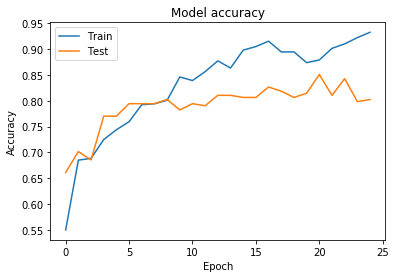

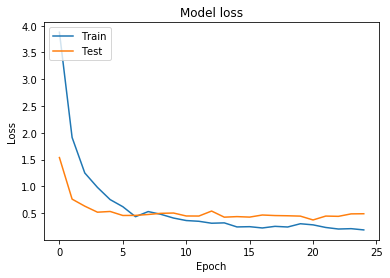

INFO:root:Accuracy is 0.8024193644523621


In [18]:
model.train(*samples)
acc = model.evaluate()
logging.info("Accuracy is {}".format(acc))

In [19]:
found_companies = model.predict(num_samples=1)
print(found_companies)

INFO:root:Running predictions for file: APPELF__0089-000000009025750-00892881_&I100PYSTB_20191017005144_01000059-09025750-00892881-001_19_.pdf
INFO:root:Testing features to predict


KeyboardInterrupt: 

In [8]:
model.analyze_result(found_companies)

NameError: name 'model' is not defined

In [9]:
# model.demo()